In [9]:
! pip install kaggle
!pip install nltk
!pip install demoji
!pip install lime
!pip install tweet-preprocessor
#https://www.kaggle.com/code/ravishekhartiwari123/explainable-ai-on-a-nlp-lstm-model-with-lime/edit
#https://www.kaggle.com/code/alikmondal/twitter-hate-speech-detection

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/credentials/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 /content/.kaggle/kaggle.json
! kaggle datasets download vkrahul/twitter-hate-speech
! unzip /content/twitter-hate-speech.zip 
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip -q glove.6B.zip

In [45]:
%matplotlib inline

import os
import re
import nltk
import lime
import demoji
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import preprocessor as p
from lime import lime_text
from tensorflow import keras
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.utils import resample
from nltk.stem import PorterStemmer
from tensorflow.keras import layers
from nltk.tokenize import word_tokenize
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer
from keras.wrappers.scikit_learn import KerasClassifier
from lime.lime_text import IndexedString,IndexedCharacters
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")


In [27]:
nltk.download('all')
demoji.download_codes()

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloadin

In [14]:
train = pd.read_csv("/content/train_E6oV3lV.csv")
test = pd.read_csv("/content/test_tweets_anuFYb8.csv")

In [15]:

def upsample(dataframe):
  
  print("Before Upsampling::",train['label'].value_counts())
  train_majority = dataframe[dataframe.label==0]
  train_minority = dataframe[dataframe.label==1]
  train_minority_upsampled = resample(train_minority, 
                                      replace=True,    
                                        n_samples=len(train_majority),   
                                        random_state=123)
  
  train_upsampled = pd.concat([train_minority_upsampled, train_majority])
  print("Sfter Upsampling::",train['label'].value_counts())
  return(train_upsampled)


train_upsampled=upsample(train)

Before Upsampling:: 0    29720
1     2242
Name: label, dtype: int64
Sfter Upsampling:: 0    29720
1     2242
Name: label, dtype: int64


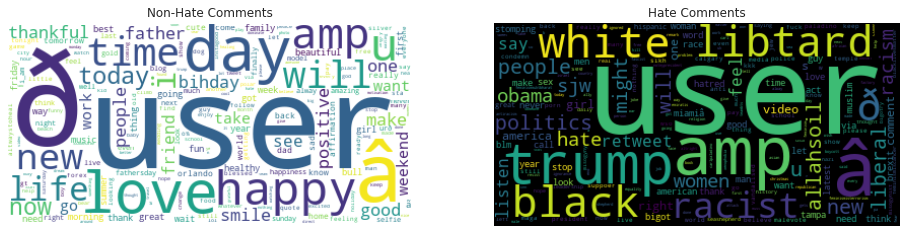

In [16]:


fig, axs = plt.subplots(1,2 , figsize=(16,8))
text_pos = " ".join(train['tweet'][train.label == 0])
text_neg = " ".join(train['tweet'][train.label == 1])
train_cloud_pos = WordCloud(collocations = False, background_color = 'white').generate(text_pos)
train_cloud_neg = WordCloud(collocations = False, background_color = 'black').generate(text_neg)
axs[0].imshow(train_cloud_pos, interpolation='bilinear')
axs[0].axis('off')
axs[0].set_title('Non-Hate Comments')
axs[1].imshow(train_cloud_neg, interpolation='bilinear')
axs[1].axis('off')
axs[1].set_title('Hate Comments')

plt.show()

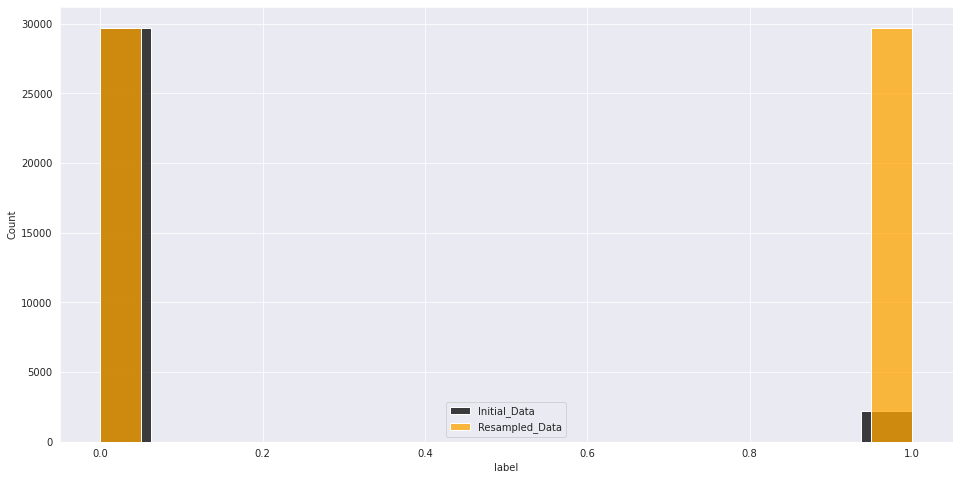

In [17]:


plt.figure(figsize=(16,8))
sns.set_style('darkgrid')
sns.histplot(data = train['label'], color='black', legend=True)
sns.histplot(data = train_upsampled['label'], color = 'orange', legend=True)
plt.legend(['Initial_Data', 'Resampled_Data'])
plt.show()

In [37]:
class preproceessing():
    
    def __init__(self,x,y,algo='BOG'):
      self.x=x
      self.y=y
      self.algo=algo

    def noemoji(self, data):
        dem = demoji.findall(str(data))
        for item in dem.keys():
          data = data.replace(item,'')
        return(data)

    def remove_punctuation(self,data):
        return(re.sub(r'[^\w\s]', '', str(data)))
    
    def preprocessing_twitter(self,data):
        data1=p.clean(str(data))
        return(data1)
    
    def tokenise_data(self,data):
        return(word_tokenize(data))

    def remove_stopwords(self,data):
        stop_words = set(stopwords.words('english'))
        return ([i for i in data if not i.lower() in stop_words])

    
    def stemming(self,data):
        ps = PorterStemmer()
        data1=""
        for w in data:
          data1=data1+" "+ps.stem(w)
        return(data1)

    def bog(self,data):
        vectorizer = CountVectorizer(max_features=512)
        bog_data=vectorizer.fit_transform(data)
        return([bog_data.toarray(),vectorizer.get_feature_names_out(),vectorizer])

    def tf_idf(self,data):
        vectorizer = TfidfVectorizer(analyzer= 'word')
        tfidf_data=vectorizer.fit_transform(data)
        return([tfidf_data.toarray(),vectorizer.get_feature_names_out(),vectorizer])
    
    def wrapper(self):
      data={
             "X":self.x,
             "Y":self.y
           }
      new_data = pd.DataFrame.from_dict(data)

      preprocessed=new_data["X"].apply(self.noemoji).apply(self.remove_punctuation).apply(self.preprocessing_twitter).apply(self.tokenise_data).apply(self.remove_stopwords).apply(self.stemming)

      if self.algo=='BOG':
        data_return=self.bog(preprocessed.values)
        return(data_return,self.y)
      elif self.algo=='TFIDF':
        data_return=self.tf_idf(preprocessed.values)
        return(data_return,self.y)  

class preprocess_test(preproceessing):

  def __init__(self,x):
      self.x=x
  def test_set(self):
        data={
             "X":self.x
            
           }
        new_data = pd.DataFrame.from_dict(data)
        preprocessed=new_data["X"].apply(self.noemoji).apply(self.remove_punctuation).apply(self.preprocessing_twitter).apply(self.tokenise_data).apply(self.remove_stopwords).apply(self.stemming)
        return(preprocessed)


 
   

In [71]:
#functions 

import math
import numpy as np
class preprocessingSequence(tf.keras.utils.Sequence):

    def __init__(self, x_set, y_set,algo="BOG",batch_size=32):
        
        self.algo=algo
        self.set=set
        self.obj_preprocessing=preproceessing(x_set, y_set)
        data,label=self.obj_preprocessing.wrapper()
        self.x= list(data[0])
        self.featuresname=data[1]
        self.vec=data[2]
        self.y=list(label)
        self.batch_size = batch_size

    def test_pre(self,data):
      
        obj=preprocess_test(data)
        datapreprocessed=obj.test_set()
        Features=self.vec.transform(datapreprocessed)
        return(Features.toarray())


    
    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)
    

    def __getitem__(self, idx):

        batch_x = self.x[idx * self.batch_size:(idx + 1) *self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return np.array(batch_x),np.array(batch_y)
    
    def return_all(self):

      return self.x,self.y
       
        
       
 
    

In [72]:
max_features = 512  

batch_size = 128
max_features = 512
tf.random.set_seed(42)

def create_model(max_features):
    
    inputs = keras.Input(shape=(None,), dtype="int32")
    x = layers.Embedding(max_features, 128)(inputs)
    x = layers.LSTM(128, return_sequences=True)(x)
    x = layers.LSTM(32)(x)
    x = layers.Dense(25, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile("adam", "binary_crossentropy", metrics=["accuracy",tf.keras.metrics.AUC()])
    return model

In [73]:
dataset_train=preprocessingSequence(train['tweet'],train['label'],'TFIDF')
dataset_test=dataset_train.test_pre(test['tweet'])

In [74]:
sklearn_lstm = KerasClassifier(build_fn=create_model, epochs=1, batch_size=32,max_features=max_features, verbose=1)
pipeline=make_pipeline(sklearn_lstm)
data_train,label_train=dataset_train.return_all()
pipeline.fit(np.asarray(data_train),np.asarray(label_train))

999/999 [==============================] - 46s 42ms/step - loss: 0.2577 - accuracy: 0.9299 - auc_10: 0.4970


Pipeline(steps=[('kerasclassifier',
                 <keras.wrappers.scikit_learn.KerasClassifier object at 0x7fd062c44710>)])

In [75]:
def predict_lime(array):
  preprocessed=dataset_train.test_pre(array)
  probability=pipeline.predict_proba(preprocessed)
  
  return(probability)

In [76]:
class_names=["Not Hate Speech", "Hate Speech"]
explainer=lime.lime_text.LimeTextExplainer(class_names=class_names)

In [77]:
exp = explainer.explain_instance(test['tweet'][34],  predict_lime, num_features=62, num_samples=50)


2/2 [==============================] - 1s 22ms/step


In [78]:
exp.show_in_notebook(text=test['tweet'][34] )

In [70]:
exp.show_in_notebook(text=test['tweet'][34] )